In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
import re
from wordcloud import WordCloud
import os
from scipy.stats import pearsonr
from scipy import stats
from tqdm import tqdm
from typing import List, Tuple




In [119]:
tqdm.pandas()

# Cargar el dataset
df = pd.read_csv('../data/raw/data_toxic.csv')

In [120]:
df

,message,label
0,"Hola, dale actualizar a la pagina o la tecla F5",0
1,Ningún mujer te va a dejar por un error. porqu...,1
2,"Entonces, si está haciendo una correspondencia...",0
3,victoria con el pelito corto me voy a matar,1
4,@LoloPeniche Periodista!!!!!\nEs una puta verd...,1
...,...,...
514550,Argentina: *apoya a la Alemania Nazi en la gue...,1
514551,La rata esta de @robertomadrazo invitando a vo...,1
514552,No dale no hay problema muchísimas gracias no ...,0
514553,"Mi nombre es ""onassis amaya cc 84083683",0


# Exploración inicial de los datos

#### Aunque el código inicial no detectó valores nulos o faltantes, una inspección manual del dataset reveló la presencia de mensajes con el texto "#ERROR!". Estos representan, en realidad, datos nulos, de modo que se añadieron al codigo para gestionar estas anomalías en los datos.

In [121]:
def check_data_quality(df):
    # Verificar valores nulos o faltantes
    null_counts = df.isnull().sum()
    null_percentages = 100 * null_counts / len(df)
    null_table = pd.concat([null_counts, null_percentages], axis=1, keys=['Total', 'Percent'])
    
    print("Valores nulos o faltantes por columna:")
    print(null_table)

    # Verificar valores vacíos en la columna 'message'
    empty_messages = df[df['message'].str.strip().eq('')]
    print(f"\nNúmero de mensajes vacíos: {len(empty_messages)}")

    # Verificar valores inválidos en la columna 'label'
    invalid_labels = df[~df['label'].isin([0, 1])]
    print(f"\nNúmero de etiquetas inválidas: {len(invalid_labels)}")

    # Verificar mensajes que contienen "#ERROR!"
    error_messages = df[df['message'].str.contains('#ERROR!', case=False, na=False)]
    print(f"\nNúmero de mensajes con '#ERROR!': {len(error_messages)}")

    # Mostrar algunos ejemplos de mensajes con error
    if not error_messages.empty:
        print("\nEjemplos de mensajes con '#ERROR!':")
        print(error_messages['message'].head())

    # Calcular el porcentaje de datos utilizables
    total_rows = len(df)
    unusable_rows = len(empty_messages) + len(invalid_labels) + len(error_messages)
    usable_percentage = 100 * (total_rows - unusable_rows) / total_rows
    print(f"\nPorcentaje de datos utilizables: {usable_percentage:.2f}%")

    return null_table, empty_messages, invalid_labels, error_messages, usable_percentage

check_data_quality(df)


Valores nulos o faltantes por columna:
         Total  Percent
message      0      0.0
label        0      0.0

Número de mensajes vacíos: 0

Número de etiquetas inválidas: 0

Número de mensajes con '#ERROR!': 7642

Ejemplos de mensajes con '#ERROR!':
5      #ERROR!
137    #ERROR!
144    #ERROR!
171    #ERROR!
193    #ERROR!
Name: message, dtype: object

Porcentaje de datos utilizables: 98.51%


(         Total  Percent
 message      0      0.0
 label        0      0.0,
 Empty DataFrame
 Columns: [message, label]
 Index: [],
 Empty DataFrame
 Columns: [message, label]
 Index: [],
         message  label
 5       #ERROR!      0
 137     #ERROR!      0
 144     #ERROR!      0
 171     #ERROR!      0
 193     #ERROR!      0
 ...         ...    ...
 514275  #ERROR!      0
 514304  #ERROR!      0
 514386  #ERROR!      0
 514446  #ERROR!      0
 514544  #ERROR!      1
 
 [7642 rows x 2 columns],
 98.51483320539107)

In [122]:

def clean_dataframe(df, inplace=False):
    """
    Limpia el DataFrame eliminando filas con '#ERROR!', mensajes vacíos, etiquetas inválidas,
    y mensajes que contienen solo símbolos sin texto legible.
    
    :param df: DataFrame original
    :param inplace: Si es True, modifica el DataFrame original. Si es False, crea una copia.
    :return: DataFrame limpio
    """
    if not inplace:
        df = df.copy()
    
    original_count = len(df)
    
    # Eliminar filas con '#ERROR!' en la columna 'message'
    df = df[~df['message'].str.contains('#ERROR!', case=False, na=False)]
    
    # Eliminar filas con mensajes vacíos
    df = df[df['message'].str.strip() != '']
    
    # Eliminar filas con etiquetas inválidas (asumiendo que las etiquetas válidas son 0 y 1)
    df = df[df['label'].isin([0, 1])]
    
    # Función para verificar si un mensaje contiene texto legible
    def contains_readable_text(text):
        # Eliminar espacios en blanco y símbolos comunes
        text = re.sub(r'[\s\.\,\!\?\-\_\+\*\#\@\(\)\[\]\{\}\<\>\:\;\'\"\~\`]', '', text)
        # Verificar si queda algún carácter alfanumérico
        return bool(re.search(r'[a-zA-Z0-9]', text))
    
    # Eliminar filas donde los mensajes no contienen texto legible
    df = df[df['message'].apply(contains_readable_text)]

    # Eliminar duplicados
    df.drop_duplicates(subset=['message', 'label'], keep='first', inplace=True)

    # Restablecer el índice
    df.reset_index(drop=True, inplace=True)
    
    cleaned_count = len(df)
    removed_count = original_count - cleaned_count
    print(f"Filas eliminadas: {removed_count}")
    print(f"Porcentaje de datos conservados: {(cleaned_count/original_count)*100:.2f}%")
    
    return df

df = clean_dataframe(df, inplace=False)

# Guardar el DataFrame limpio
output_path = '../data/processed/data_toxic_cleaned.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"DataFrame limpio guardado en: {output_path}")


Filas eliminadas: 32359
Porcentaje de datos conservados: 93.71%
DataFrame limpio guardado en: ../data/processed/data_toxic_cleaned.csv


#### Se analiza la distribución de clases para entender la proporción de mensajes tóxicos y no tóxicos en el dataset. Esto para identificar posibles desbalances y con eso ajustar la estrategia de modelado y la evaluación de resultados.

Distribución de clases:
            Count  Percentage
label                        
No tóxico  289467   60.030983
Tóxico     192729   39.969017


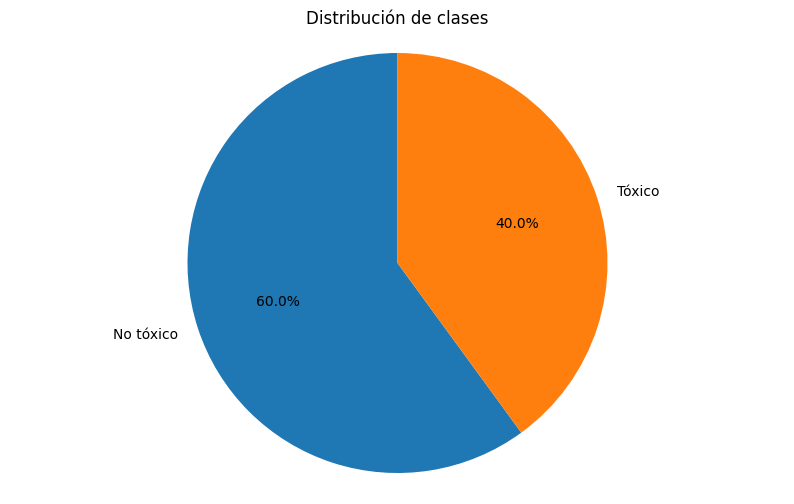


Ratio de desbalance (No tóxico : Tóxico): 1.50 : 1


In [123]:
# Calcular la distribución de clases
class_distribution = df['label'].value_counts()
class_distribution_percentage = df['label'].value_counts(normalize=True) * 100

# Crear un DataFrame con los resultados
distribution_df = pd.DataFrame({
    'Count': class_distribution,
    'Percentage': class_distribution_percentage
})

# Renombrar los índices para mayor claridad
distribution_df = distribution_df.rename(index={0: 'No tóxico', 1: 'Tóxico'})

# Mostrar la tabla de distribución
print("Distribución de clases:")
print(distribution_df)

# Visualización con gráfico de pastel
plt.figure(figsize=(10, 6))
plt.pie(distribution_df['Count'], labels=distribution_df.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de clases')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Calcular el desbalance de clases
imbalance_ratio = distribution_df.loc['No tóxico', 'Count'] / distribution_df.loc['Tóxico', 'Count']
print(f"\nRatio de desbalance (No tóxico : Tóxico): {imbalance_ratio:.2f} : 1")


#### El dataset muestra un ligero desbalance a favor de la clase "No tóxico". Con una proporción de 1.50:1, el desbalance no es extremo, pero se considerará en el modelado para evitar sesgos hacia la clase mayoritaria.

Se analiza la longitud de los mensajes por clase para identificar si existe una relación entre la longitud del mensaje y su toxicidad. 

Estadísticas de longitud por clase:
          count        mean        std  min   25%    50%    75%     max
label                                                                  
0      289467.0  129.733527  98.821270  4.0  61.0  103.0  175.0  5007.0
1      192729.0  128.467584  91.730849  4.0  59.0  103.0  184.0  5000.0


<Figure size 1000x600 with 0 Axes>

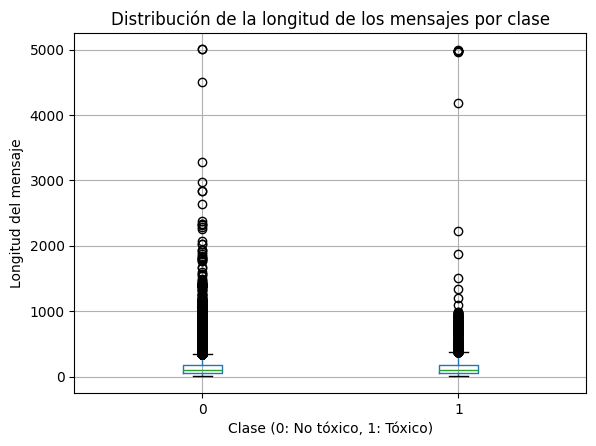

Coeficiente de correlación de Pearson: -0.0065
Valor p: 0.0000

Correlación punto biserial: -0.0065
Valor p (correlación punto biserial): 0.0000


In [124]:
# Calcular la longitud de cada mensaje
df['message_length'] = df['message'].str.len()

# Calcular estadísticas descriptivas de la longitud por clase
length_stats = df.groupby('label')['message_length'].describe()

print("Estadísticas de longitud por clase:")
print(length_stats)

# Crear un boxplot de la longitud de los mensajes por clase
plt.figure(figsize=(10, 6))
df.boxplot(column='message_length', by='label')
plt.title('Distribución de la longitud de los mensajes por clase')
plt.suptitle('')
plt.xlabel('Clase (0: No tóxico, 1: Tóxico)')
plt.ylabel('Longitud del mensaje')
plt.show()

# Calcular la correlación
correlation, p_value = stats.pearsonr(df['message_length'], df['label'])

print(f"Coeficiente de correlación de Pearson: {correlation:.4f}")
print(f"Valor p: {p_value:.4f}")

# Calcular la correlación punto biserial (alternativa para variables dicotómicas)
point_biserial_corr, pb_p_value = stats.pointbiserialr(df['label'], df['message_length'])

print(f"\nCorrelación punto biserial: {point_biserial_corr:.4f}")
print(f"Valor p (correlación punto biserial): {pb_p_value:.4f}")

1. Las longitudes medias son muy similares: 129.7 caracteres para mensajes no tóxicos y 130.3 para tóxicos.

2. La desviación estándar es ligeramente mayor en mensajes no tóxicos (98.8 vs 91.8), indicando una variabilidad un poco mayor.

3. Los valores mínimos y máximos son prácticamente idénticos para ambas clases.

4. La mediana (50%) es ligeramente mayor para mensajes tóxicos (105 vs 103).

5. El tercer cuartil (75%) es notablemente mayor para mensajes tóxicos (188 vs 175), sugiriendo que los mensajes tóxicos más largos tienden a ser más extensos que los no tóxicos más largos.

Estas estadísticas indican que la longitud del mensaje por sí sola no es un indicador fuerte de toxicidad:
 - La correlación entre la longitud del mensaje y su toxicidad es extremadamente débil (-0.0065). Esto sugiere que la longitud del texto prácticamente no influye en su toxicidad. Para la detección de contenido ofensivo, se deben considerar otros factores.

Correlación entre porcentaje de mayúsculas y toxicidad: 0.20210868511825314
Valor p: 0.0


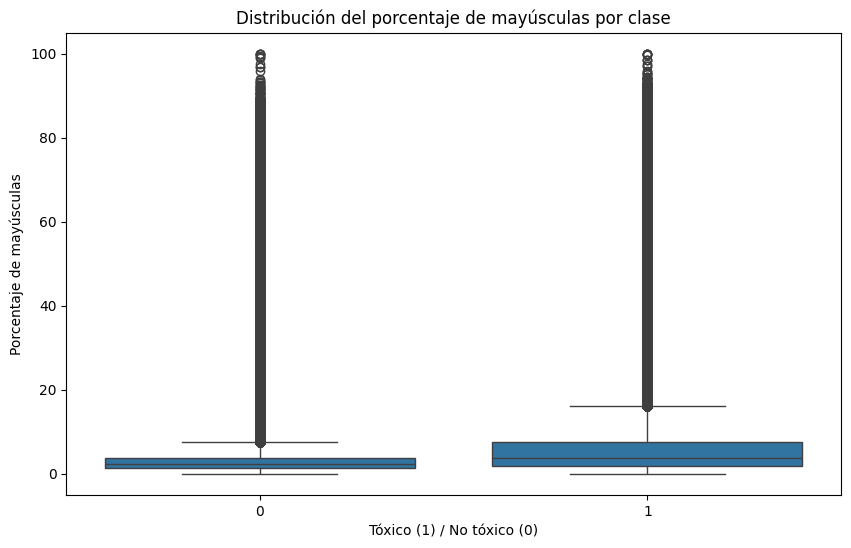

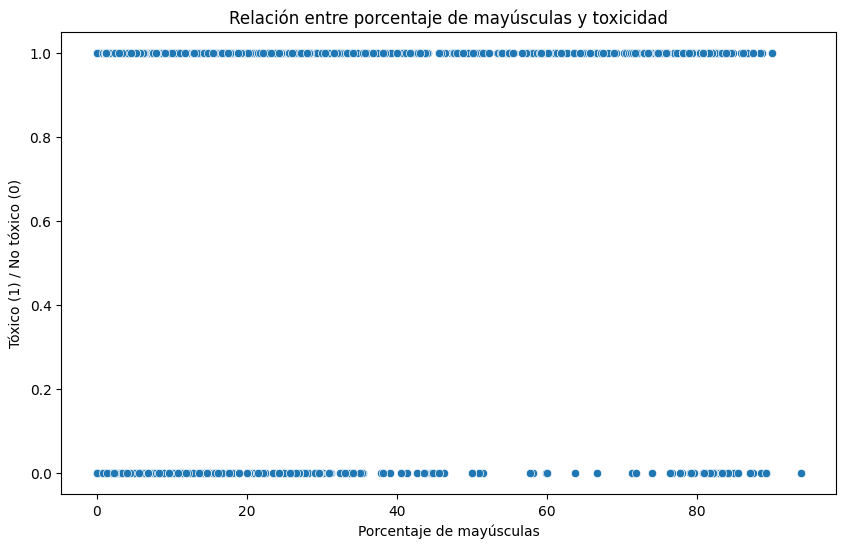

In [134]:
# Función para calcular el porcentaje de mayúsculas en un texto
def porcentaje_mayusculas(texto):
    if not isinstance(texto, str):
        return 0
    total_caracteres = len(texto)
    mayusculas = sum(1 for c in texto if c.isupper())
    return (mayusculas / total_caracteres) * 100 if total_caracteres > 0 else 0

# Calcular el porcentaje de mayúsculas para cada mensaje
df['porcentaje_mayusculas'] = df['message'].apply(porcentaje_mayusculas)

# Calcular la correlación
correlacion, p_valor = pearsonr(df['porcentaje_mayusculas'], df['label'])

print(f"Correlación entre porcentaje de mayúsculas y toxicidad: {correlacion}")
print(f"Valor p: {p_valor}")

# Visualización
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='porcentaje_mayusculas', data=df)
plt.title('Distribución del porcentaje de mayúsculas por clase')
plt.xlabel('Tóxico (1) / No tóxico (0)')
plt.ylabel('Porcentaje de mayúsculas')
plt.show()

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='porcentaje_mayusculas', y='label', data=df.sample(n=10000, random_state=42))
plt.title('Relación entre porcentaje de mayúsculas y toxicidad')
plt.xlabel('Porcentaje de mayúsculas')
plt.ylabel('Tóxico (1) / No tóxico (0)')
plt.show()


Existe una correlación débil pero estadísticamente significativa (0.203, p < 0.001) entre el uso de mayúsculas y la toxicidad en los textos. Esto indica que los mensajes tóxicos tienden a utilizar ligeramente más mayúsculas. Sin embargo, la baja magnitud de la correlación indica que este factor por sí solo no es un predictor fuerte de toxicidad. Esta característica podría ser útil como parte de un conjunto más amplio de indicadores en un modelo de detección de toxicidad, pero no debería considerarse de manera aislada.


Coeficiente phi: 0.6156
Valor p: 0.0000


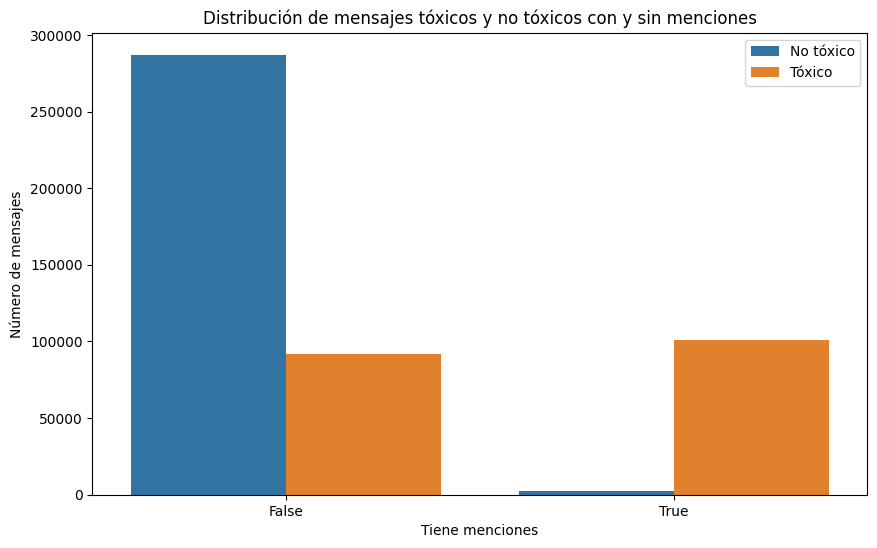

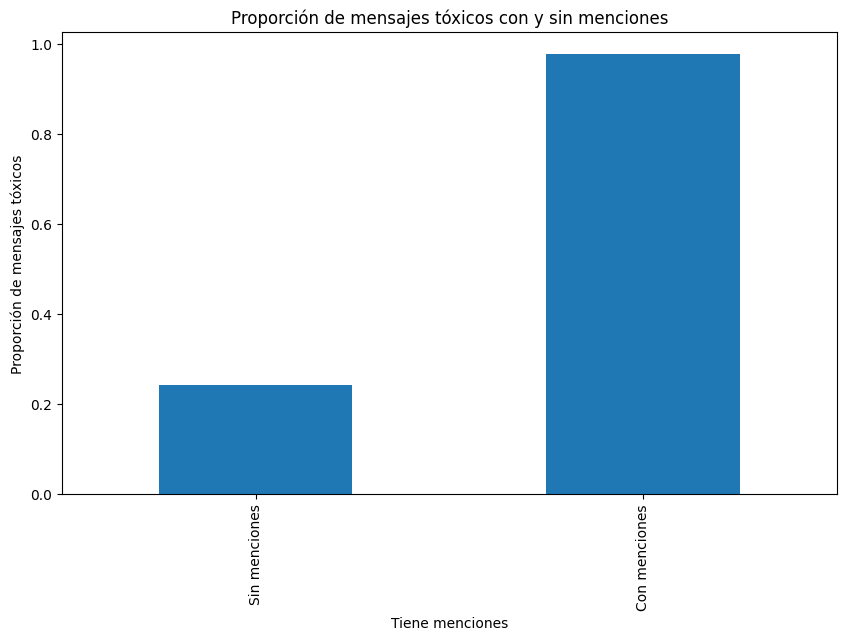

In [135]:
# Función para detectar si hay menciones en un texto
def tiene_menciones(texto):
    if not isinstance(texto, str):
        return False
    return bool(re.search(r'@\w+', texto))

# Aplicar la función a la columna 'message'
df['tiene_menciones'] = df['message'].apply(tiene_menciones)

# Calcular la correlación phi ( que esta mejor pensada para medir correlacion entre dos variables binarias )
contingency_table = pd.crosstab(df['tiene_menciones'], df['label'])
chi2, _, _, _ = stats.chi2_contingency(contingency_table)
n = contingency_table.sum().sum()
phi_coefficient = np.sqrt(chi2 / n)

# Calcular el valor p
df_freedom = 1
p_value = 1 - stats.chi2.cdf(chi2, df_freedom)

print(f"Coeficiente phi: {phi_coefficient:.4f}")
print(f"Valor p: {p_value:.4f}")

# Visualización
plt.figure(figsize=(10, 6))
sns.countplot(x='tiene_menciones', hue='label', data=df)
plt.title('Distribución de mensajes tóxicos y no tóxicos con y sin menciones')
plt.xlabel('Tiene menciones')
plt.ylabel('Número de mensajes')
plt.legend(['No tóxico', 'Tóxico'])
plt.show()

# Gráfico de barras para la proporción de mensajes tóxicos con y sin menciones
prop_toxic = df.groupby('tiene_menciones')['label'].mean()

plt.figure(figsize=(10, 6))
prop_toxic.plot(kind='bar')
plt.title('Proporción de mensajes tóxicos con y sin menciones')
plt.xlabel('Tiene menciones')
plt.ylabel('Proporción de mensajes tóxicos')
plt.xticks([0, 1], ['Sin menciones', 'Con menciones'])
plt.show()

#### Al inspeccionar el dataset, se observó una alta frecuencia de menciones (@usuario) en los mensajes, lo que llevó a investigar su posible relación con la toxicidad. 
#### El análisis reveló una correlación significativa entre la presencia de menciones y la toxicidad del texto, con un coeficiente phi de 0.6156 (p < 0.0001). Este valor indica una asociación moderada a fuerte, sugiriendo que los mensajes con menciones tienen una mayor probabilidad de ser tóxicos. La significancia estadística (p = 0.0000) confirma que esta relación no es aleatoria. Este hallazgo podría ser valioso para mejorar los modelos de detección de toxicidad, ya que la presencia de menciones parece ser un indicador importante del tono y la intención del mensaje.

# Análisis de frecuencia de palabras en mensajes tóxicos vs. no tóxicos


In [136]:
# Descargar stopwords en español
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('spanish'))

STOP_WORDS.add('q')
STOP_WORDS.add('si')
STOP_WORDS.add('ser')
STOP_WORDS.add('va')

def get_top_words(texts, n=20):
    """Obtiene las palabras más frecuentes de una lista de textos."""
    words = ' '.join(texts).split()
    return Counter(words).most_common(n)

def create_wordcloud(text: str, title: str) -> None:
    """
    Crea y muestra una nube de palabras a partir del texto dado.
    
    Args:
    text (str): El texto para generar la nube de palabras.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


def relative_frequency(words, total_words):
    """Calcula la frecuencia relativa de las palabras."""
    return {word: count / total_words for word, count in words}

def preprocess_text(text):
    """
    Preprocesa el texto: convierte a minúsculas, elimina URLs, elimina caracteres especiales y stopwords,
    reemplaza las menciones (@username) con un token estándar, mantiene los hashtags,
    elimina menciones duplicadas y reemplaza números completos con [NUMERO].
    """
    # Convierte a minúsculas
    text = text.lower()
    
    # Elimina URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Reemplaza las menciones (@username) con [MENCION]
    text = re.sub(r'@\w+', '[MENCION]', text)
    
    # Elimina el símbolo '#' pero mantiene el texto del hashtag
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Reemplaza números completos con [NUMERO]
    text = re.sub(r'\b\d+\b', '', text)
    
    # Elimina caracteres especiales, incluyendo el guion bajo, pero manteniendo [MENCION] y [NUMERO]
    text = re.sub(r'[^\w\s\[MENCION\]\[NUMERO\]#]|_', '', text)
    
    # Divide el texto en palabras y elimina las stopwords
    words = text.split()
    words = [word for word in words if word not in STOP_WORDS]
    
    # Elimina menciones duplicadas
    mention_found = False
    filtered_words = []
    for word in words:
        if word == '[MENCION]':
            if not mention_found:
                filtered_words.append(word)
                mention_found = True
        else:
            filtered_words.append(word)
    
    return ' '.join(filtered_words).strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jhon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Antes de hacer el analisis de frecuencia se preprocesa para eliminar ruido 

In [137]:
# Preprocesar los mensajes
print('preprocesar texto')
df['processed_message'] = df['message'].progress_apply(preprocess_text)


preprocesar texto


100%|███████████████████████████████████████████████████████████████████████| 482196/482196 [00:05<00:00, 82761.48it/s]


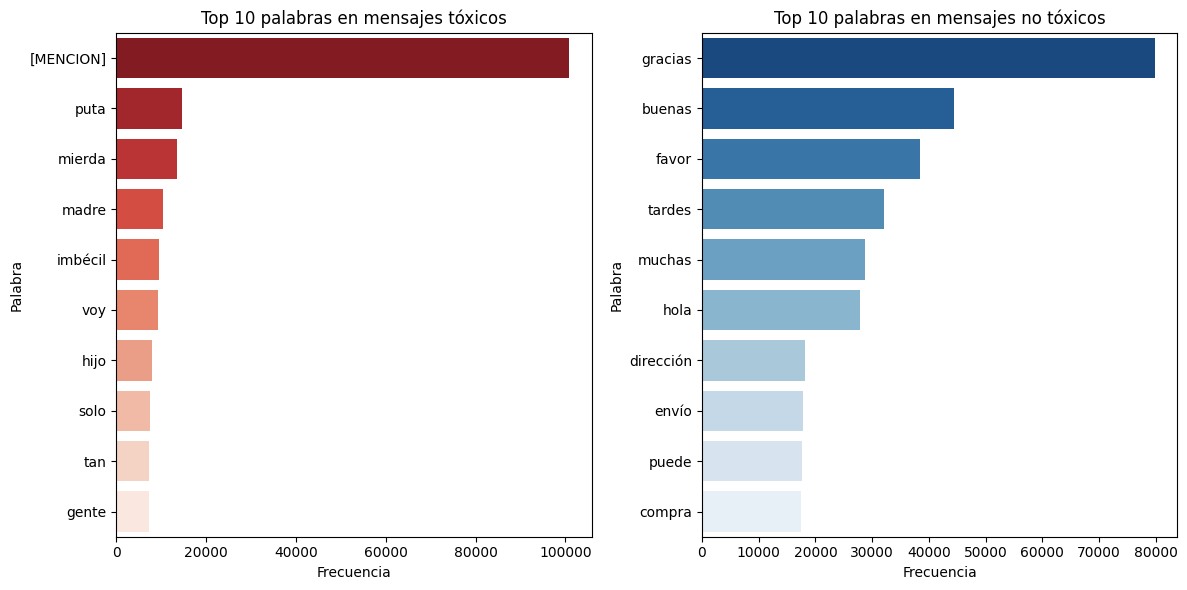

In [138]:
# Obtener las palabras más frecuentes para cada clase
toxic_words = get_top_words(df[df['label'] == 1]['processed_message'])
non_toxic_words = get_top_words(df[df['label'] == 0]['processed_message'])

# Crear DataFrames para las palabras más frecuentes
toxic_df = pd.DataFrame(toxic_words, columns=['word', 'count'])
non_toxic_df = pd.DataFrame(non_toxic_words, columns=['word', 'count'])

# Visualización: Gráfico de barras para las palabras más frecuentes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=toxic_df.head(10), hue='word', palette='Reds_r', legend=False)
plt.title('Top 10 palabras en mensajes tóxicos')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')

plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=non_toxic_df.head(10), hue='word', palette='Blues_r', legend=False)
plt.title('Top 10 palabras en mensajes no tóxicos')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')

plt.tight_layout()
plt.show()


- El análisis de frecuencia de palabras revela patrones distintivos entre mensajes tóxicos y no tóxicos. Los mensajes tóxicos se caracterizan por un alto uso de menciones, lenguaje ofensivo, amenazas y insultos específicos. En contraste, los mensajes no tóxicos muestran un lenguaje cortés y están relacionados con conversaciones cotidianas. La presencia de menciones en mensajes tóxicos sugiere que la toxicidad a menudo ocurre en interacciones directas.
- Esto sugiere que sería más efectivo utilizar un embedding contextual, como BERT o similares, en lugar de embeddings estáticos. Los embeddings contextuales podrían capturar mejor los matices y significados cambiantes de las palabras.

In [139]:
def get_top_words(texts, n=20):
    """Obtiene las palabras más frecuentes de una lista de textos."""
    words = ' '.join(texts).split()
    return Counter(words).most_common(n)

def create_wordcloud(text: str, title: str) -> None:
    """
    Crea y muestra una nube de palabras a partir del texto dado.
    
    Args:
    text (str): El texto para generar la nube de palabras.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


def relative_frequency(words, total_words):
    """Calcula la frecuencia relativa de las palabras."""
    return {word: count / total_words for word, count in words}


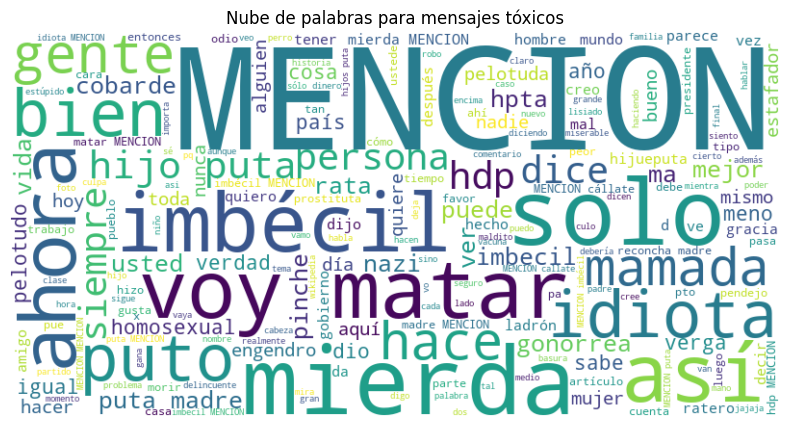

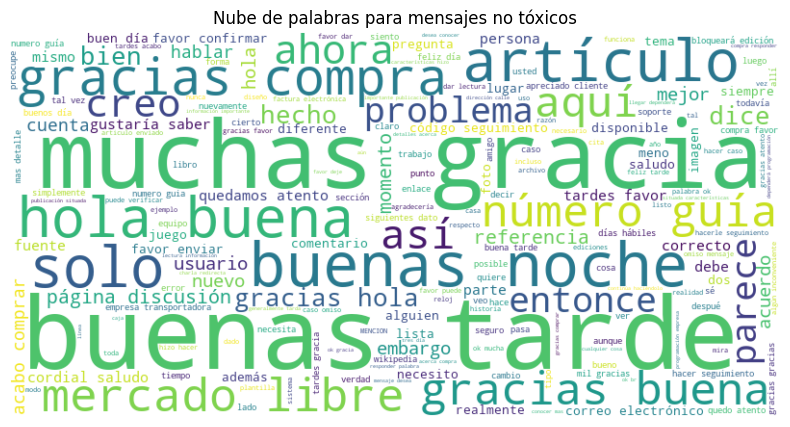

In [140]:
# Visualización: Nube de palabras para cada clase
create_wordcloud(' '.join(df[df['label'] == 1]['processed_message']), 'Nube de palabras para mensajes tóxicos')
create_wordcloud(' '.join(df[df['label'] == 0]['processed_message']), 'Nube de palabras para mensajes no tóxicos')


# Analisis de N-gramas

In [142]:
def get_top_ngrams(texts: List[str], n: int, top_k: int = 20) -> List[Tuple[Tuple[str, ...], int]]:
    """
    Obtiene los n-gramas más frecuentes de una lista de textos.
    
    Args:
    texts (List[str]): Lista de textos preprocesados.
    n (int): Tamaño del n-grama (2 para bigramas, 3 para trigramas, etc.).
    top_k (int): Número de n-gramas más frecuentes a retornar.
    
    Returns:
    List[Tuple[Tuple[str, ...], int]]: Lista de tuplas (n-grama, frecuencia).
    """
    all_ngrams = []
    for text in texts:
        words = text.split()
        all_ngrams.extend(ngrams(words, n))
    return Counter(all_ngrams).most_common(top_k)

def plot_ngrams(ngrams: List[Tuple[Tuple[str, ...], int]], title: str) -> None:
    """
    Crea un gráfico de barras horizontales para los n-gramas.
    
    Args:
    ngrams (List[Tuple[Tuple[str, ...], int]]): Lista de tuplas (n-grama, frecuencia).
    title (str): Título del gráfico.
    """
    ngrams_str = [' '.join(ng[0]) for ng in ngrams]
    counts = [ng[1] for ng in ngrams]
    
    plt.figure(figsize=(12, 8))
    plt.barh(ngrams_str, counts)
    plt.title(title)
    plt.xlabel('Frecuencia')
    plt.ylabel('N-gramas')
    plt.gca().invert_yaxis()  # Invierte el eje y para que el más frecuente esté arriba
    plt.tight_layout()
    plt.show()

def analyze_ngrams(df: pd.DataFrame, n: int = 2) -> None:
    """
    Analiza y visualiza los n-gramas más frecuentes en mensajes tóxicos y no tóxicos.
    
    Args:
    df (pd.DataFrame): DataFrame con los datos.
    n (int): Tamaño del n-grama (2 para bigramas, 3 para trigramas, etc.).
    """
    toxic_ngrams = get_top_ngrams(df[df['label'] == 1]['processed_message'], n)
    non_toxic_ngrams = get_top_ngrams(df[df['label'] == 0]['processed_message'], n)
    
    plot_ngrams(toxic_ngrams, f"Top {len(toxic_ngrams)} {n}-gramas en mensajes tóxicos")
    plot_ngrams(non_toxic_ngrams, f"Top {len(non_toxic_ngrams)} {n}-gramas en mensajes no tóxicos")


Análisis de bigramas:


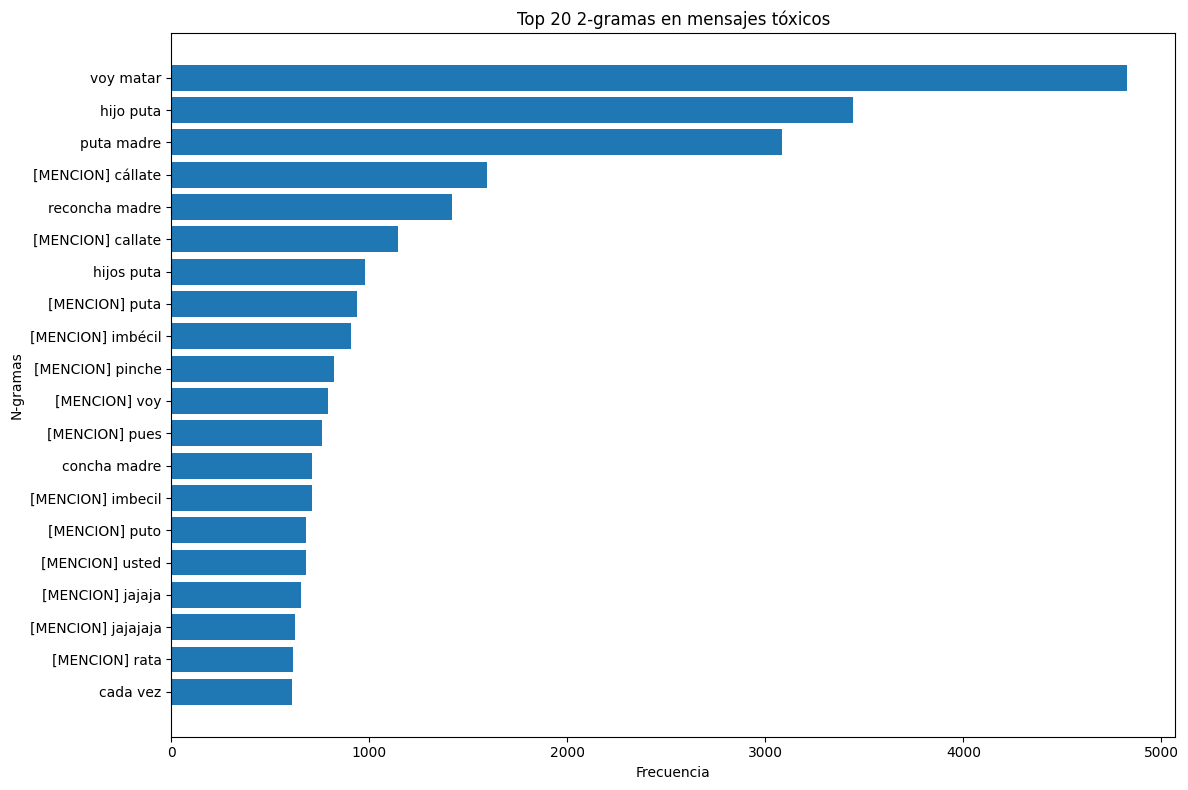

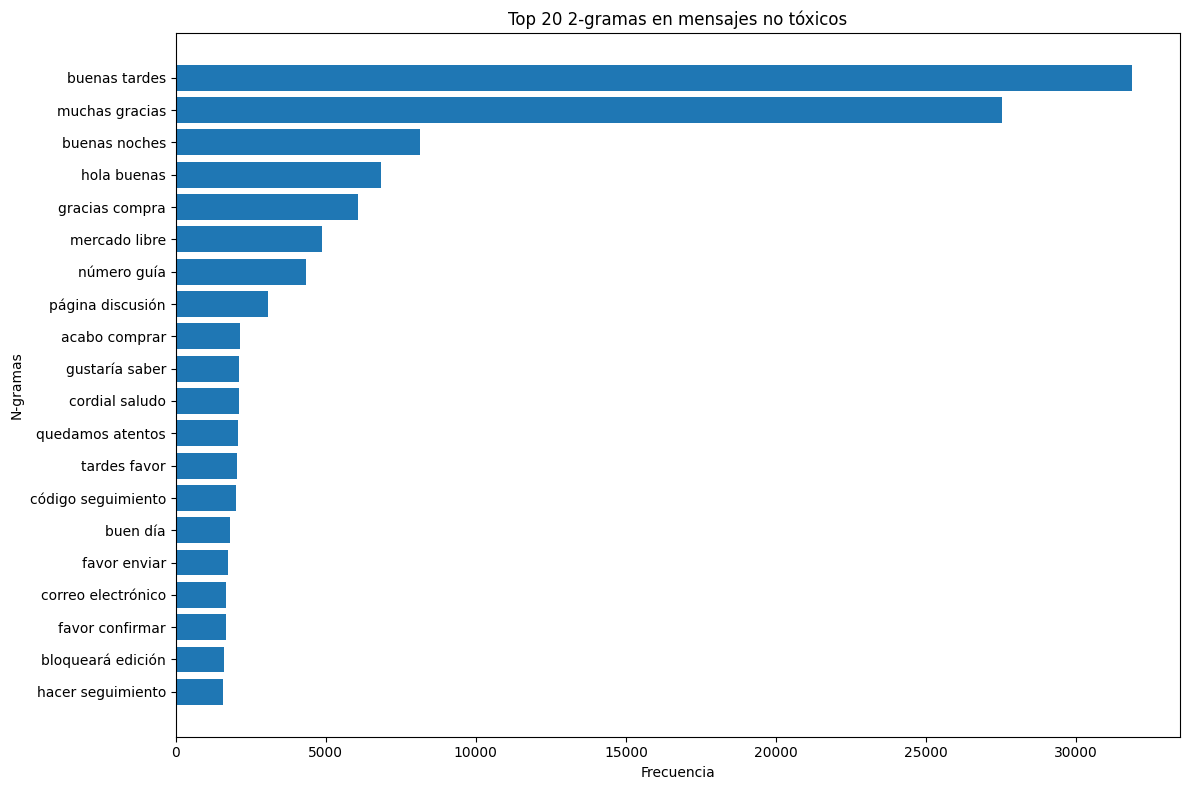


Análisis de trigramas:


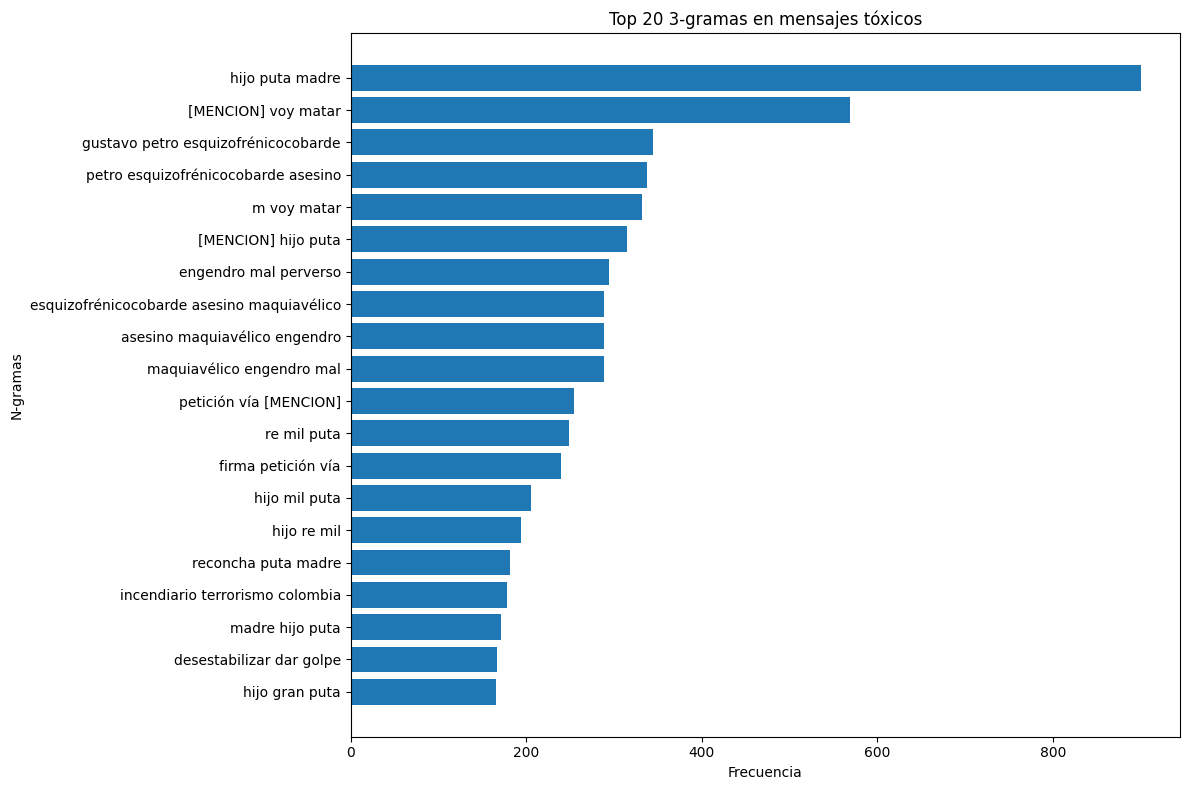

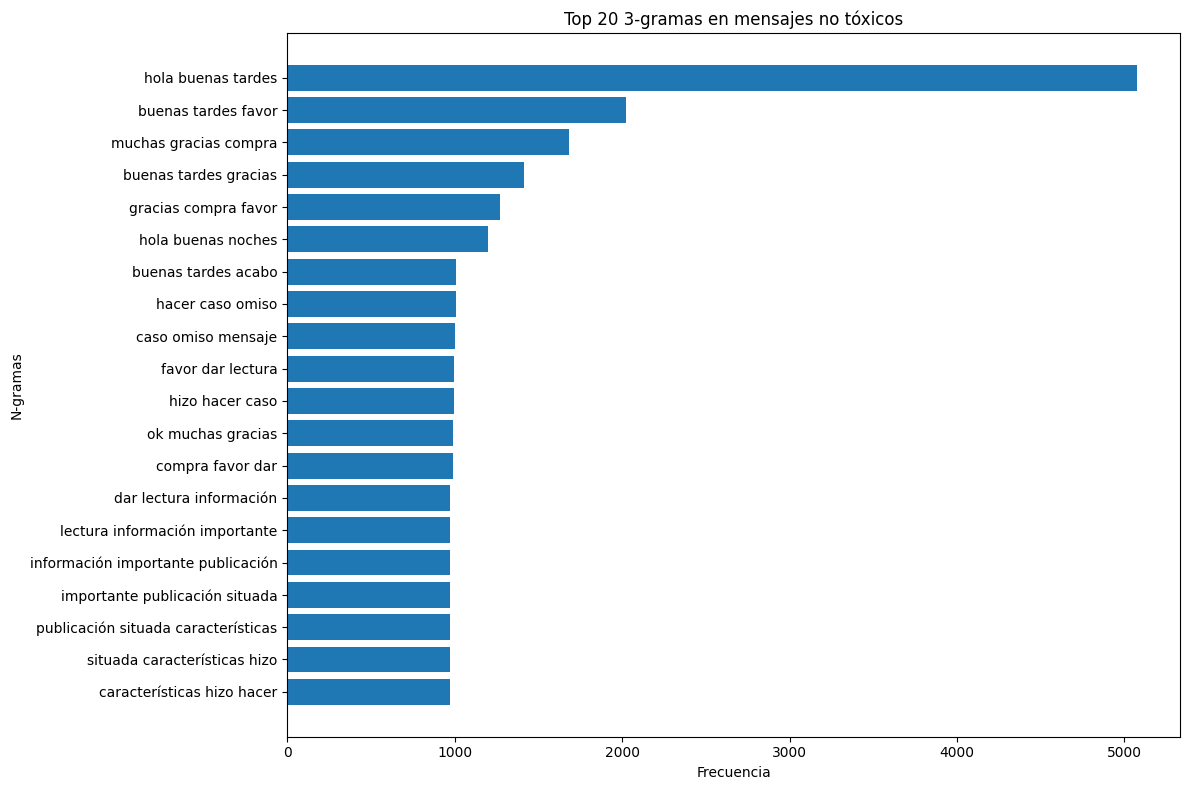

In [143]:
# Análisis de bigramas
print("Análisis de bigramas:")
analyze_ngrams(df, n=2)

# Análisis de trigramas
print("\nAnálisis de trigramas:")
analyze_ngrams(df, n=3)

- Los mensajes tóxicos se caracterizan por el uso frecuente de insultos, amenazas y lenguaje agresivo, a menudo dirigidos a individuos específicos mediante menciones. También se observan referencias a temas políticos y acusaciones. En contraste, los mensajes no tóxicos muestran un lenguaje cortés y formal, típico de interacciones comerciales o de servicio al cliente. Incluyen saludos, agradecimientos y frases relacionadas con transacciones o solicitudes de información. Esta marcada diferencia en el uso del lenguaje proporciona insights valiosos sobre las características distintivas de los mensajes tóxicos y no tóxicos